In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.patches as patches

import pylab as plt
#!pip install --user gpy 
#!pip install --user plotly 

import GPy
from IPython.display import display

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering
from sklearn.cluster import DBSCAN




#GPy.plotting.change_plotting_library('plotly')
GPy.plotting.change_plotting_library('plotly_offline')

sns.set(color_codes=True)

### Load data
Load raw data, drop some values missed in data preparation, drop unnecessary columns, show data head

In [64]:
data_raw = pd.read_csv('data/cleaned_data2.csv').drop(columns=['Unnamed: 0'])
print(len(data_raw))

# Drop some bad samples from data
data_raw = data_raw[data_raw.number_of_rooms != ' ']
data_raw = data_raw[data_raw.dist_center < 100]

print(data_raw.isnull().sum())
# Energy class has 1105 na:s, the rest of the columns only a few. We drop the energy class column completely.

# Drop unnecessary columns, they are still in data_raw if needed later
data = data_raw.drop(columns=['neighborhood', 'rooms', 'energy_class'])
data = data.dropna()
print(len(data))
data.head(5)

3432
type_kt                      0
type_rt                      0
type_ok                      0
elevator                     0
energy_class              1105
neighborhood                 0
price                        0
price_per_square_meter       0
number_of_rooms             16
rooms                        1
square_meters                0
year                         0
condition                    0
floor_num                   35
top_floor                   35
bottom_floor                35
floor_frac                  35
lat                          0
lng                          0
dist_center                  0
dtype: int64
3327


,type_kt,type_rt,type_ok,elevator,price,price_per_square_meter,number_of_rooms,square_meters,year,condition,floor_num,top_floor,bottom_floor,floor_frac,lat,lng,dist_center
0,1,0,0,1,191050,10055,1,19.0,1929,2,5.0,True,False,1.000000,60.167458,24.931075,0.485608
1,1,0,0,0,143000,5789,1,24.7,1957,1,3.0,False,False,0.750000,60.206704,24.871212,5.544540
2,1,0,0,1,167000,6680,1,25.0,1940,1,6.0,True,False,1.000000,60.188258,24.955949,2.270341
3,1,0,0,0,157000,6181,1,25.4,1951,1,1.0,False,False,0.250000,60.202747,24.905494,4.093763
4,1,0,0,0,133000,4926,1,27.0,1961,2,2.0,False,False,0.666667,60.212173,25.096109,9.939839


## Data exploration
In this section we explore the data to get a better understanding of it

### Plot variables
Next, we plot some variables to get a feel for the dataset. The goal of this project is to predict price per $m^2$, so most of the plots have that variable on y axis

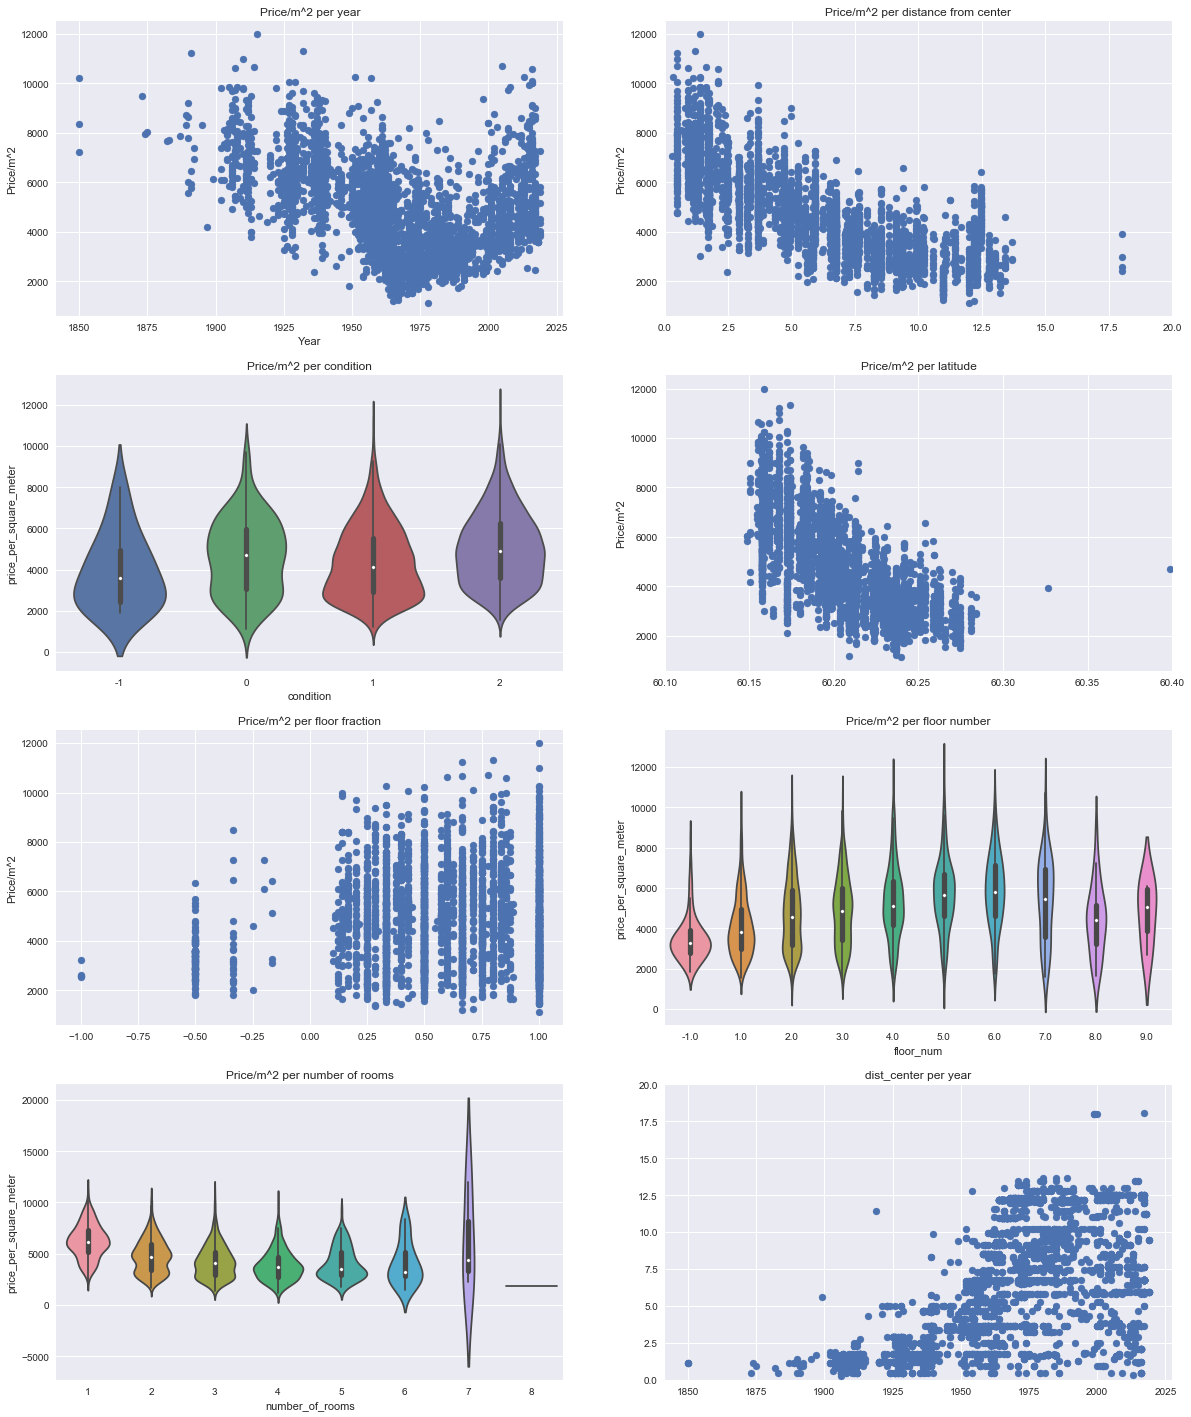

In [65]:
# Plot some shit
plt.figure(figsize=(20, 25))
plt.subplot(4,2,1)
plt.title('Price/m^2 per year')
plt.xlabel('Year')
plt.ylabel('Price/m^2')
plt.scatter(data=data, x='year', y='price_per_square_meter')

plt.subplot(4,2,2)
plt.xlim(0, 20)
plt.title('Price/m^2 per distance from center')
plt.ylabel('Price/m^2')
plt.scatter(data=data, x='dist_center', y='price_per_square_meter')

plt.subplot(4,2,3)
#plt.xlim(0, 20)
plt.title('Price/m^2 per condition')
plt.ylabel('Price/m^2')
sns.violinplot(data=data, x='condition', y='price_per_square_meter')

plt.subplot(4,2,4)
plt.xlim(60.1, 60.4)
plt.title('Price/m^2 per latitude')
plt.ylabel('Price/m^2')
plt.scatter(data=data, x='lat', y='price_per_square_meter')

plt.subplot(4,2,5)
plt.title('Price/m^2 per floor fraction')
plt.ylabel('Price/m^2')
plt.scatter(data=data, x='floor_frac', y='price_per_square_meter')

plt.subplot(4,2,6)
plt.title('Price/m^2 per floor number')
sns.violinplot(data=data, x='floor_num', y='price_per_square_meter', jitter=True)

plt.subplot(4,2,7)
plt.title('Price/m^2 per number of rooms')
sns.violinplot(data=data, x='number_of_rooms', y='price_per_square_meter', jitter=True)

plt.subplot(4,2,8)
plt.title('dist_center per year')
plt.ylim(0, 20)
plt.scatter(data=data, x='year', y='dist_center')


#plt.savefig('fig/year_price_scatter.eps', format='eps')

### Correlation plot
Correlation plot gives nice overview of the variable correlations. Interesting observations include that price per square meter and price differ on a number of variables, such as house type. Year and distance from city center also correlate.

Text(0.5,1,'Correlation plot')

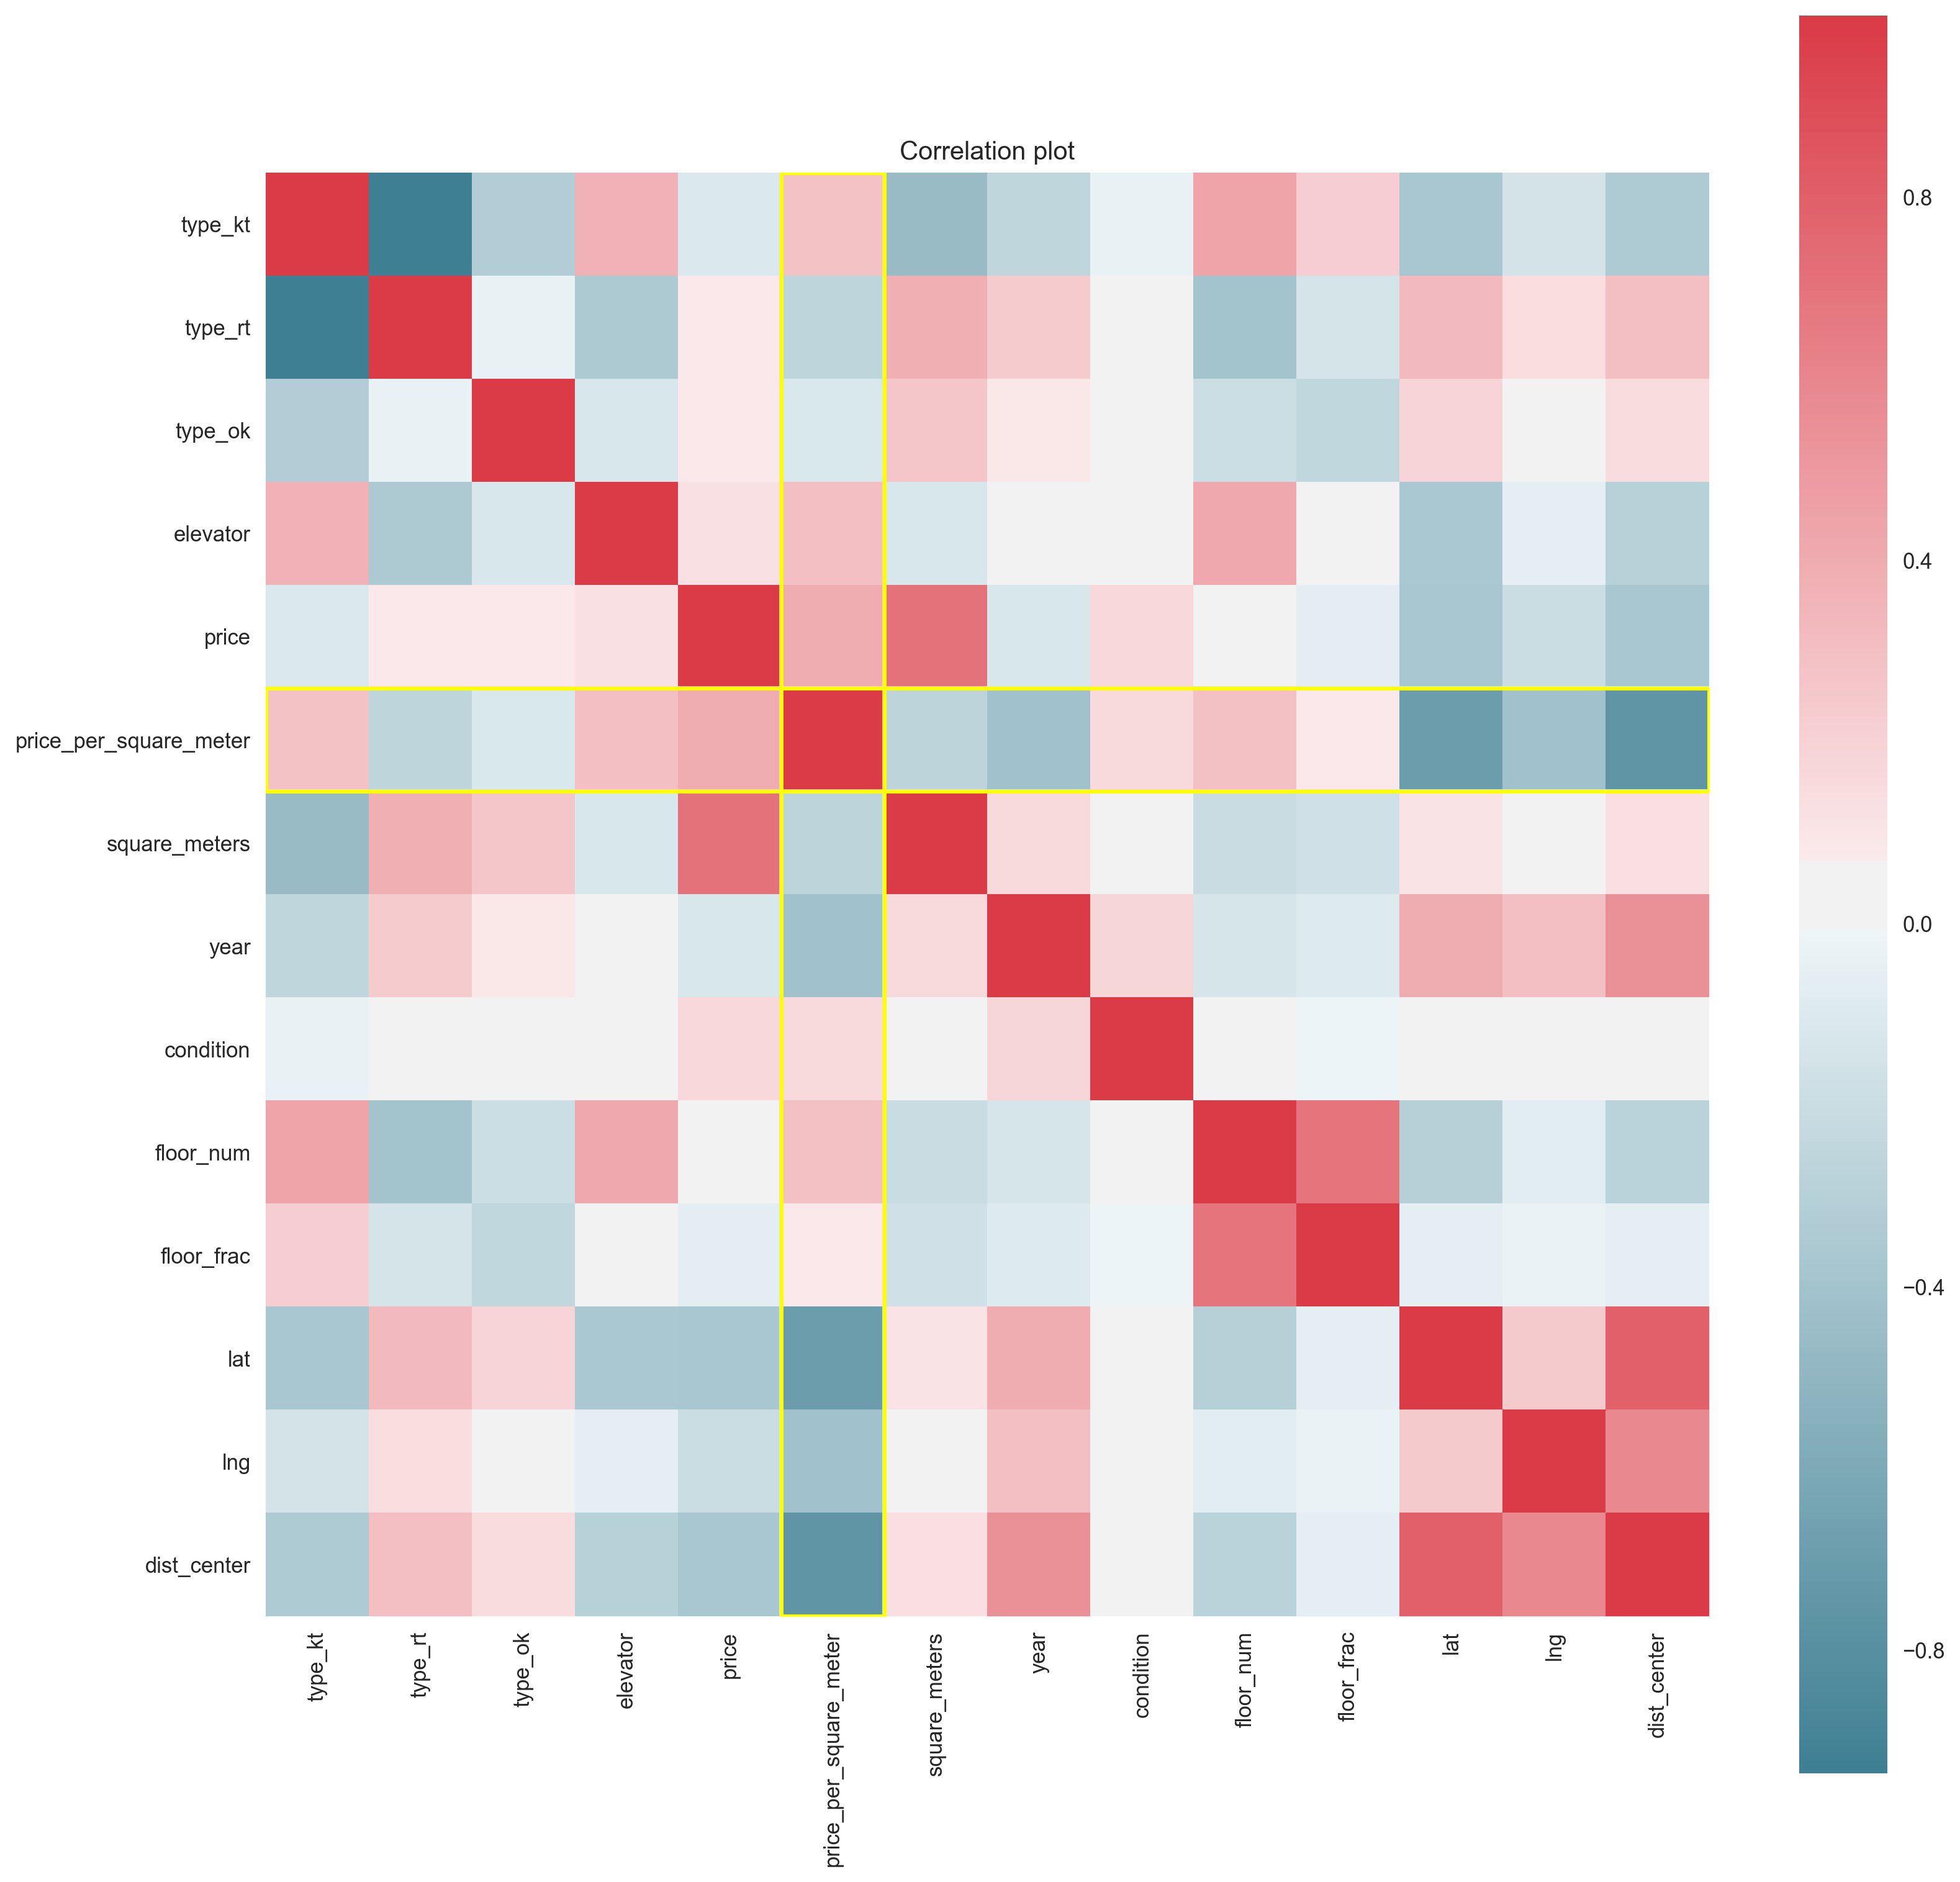

In [66]:
corr = data.corr()
f, ax = plt.subplots(figsize=(15, 15), dpi=250)
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

ax.add_patch(
    patches.Rectangle(
        (5, 0),
        1,
        14,
        fill=False,
        linewidth=2,
        color='yellow'
    )
)
ax.add_patch(
    patches.Rectangle(
            (0, 5),
            14,
            1,
            fill=False,
            linewidth=2,
            color='yellow'
    )
)

plt.title('Correlation plot')

### TSNE embedding
Next, we do tsne embedding to visualize the whole dataset in 2D. Price related variables are dropped as we wish to predict those variables and as such can use them to color the tsne plots to see if any clusters form where the price or price per square meter are different.

We plot a couple of more tsne plots where the coloring is some other interesting variable.

The resulting plots show somewhat neat clusters. In the bottom row, they are colored based on kmeans and DBSCAN clustering algorithm. For example, it seems that the top left cluster represents new houses in good condition. The two clusters on the right represent older houses in varying conditions near the center of the city.

The results suggest that neighbor or distance based models might perform well on this task. 

In [67]:
# TSNE, drop price and price per square meter as we want to predict those variables
data_tsne_embedded = TSNE(n_components=2).fit_transform(data.drop(columns=['price', 'price_per_square_meter']))

In [68]:
# Calculate kmeans and spectral clusters on the data for cluster visualization
kmeans = KMeans(n_clusters=8).fit(data_tsne_embedded)
kmeans_labels = kmeans.labels_

dbscan_labels = DBSCAN(eps=3).fit_predict(data_tsne_embedded)

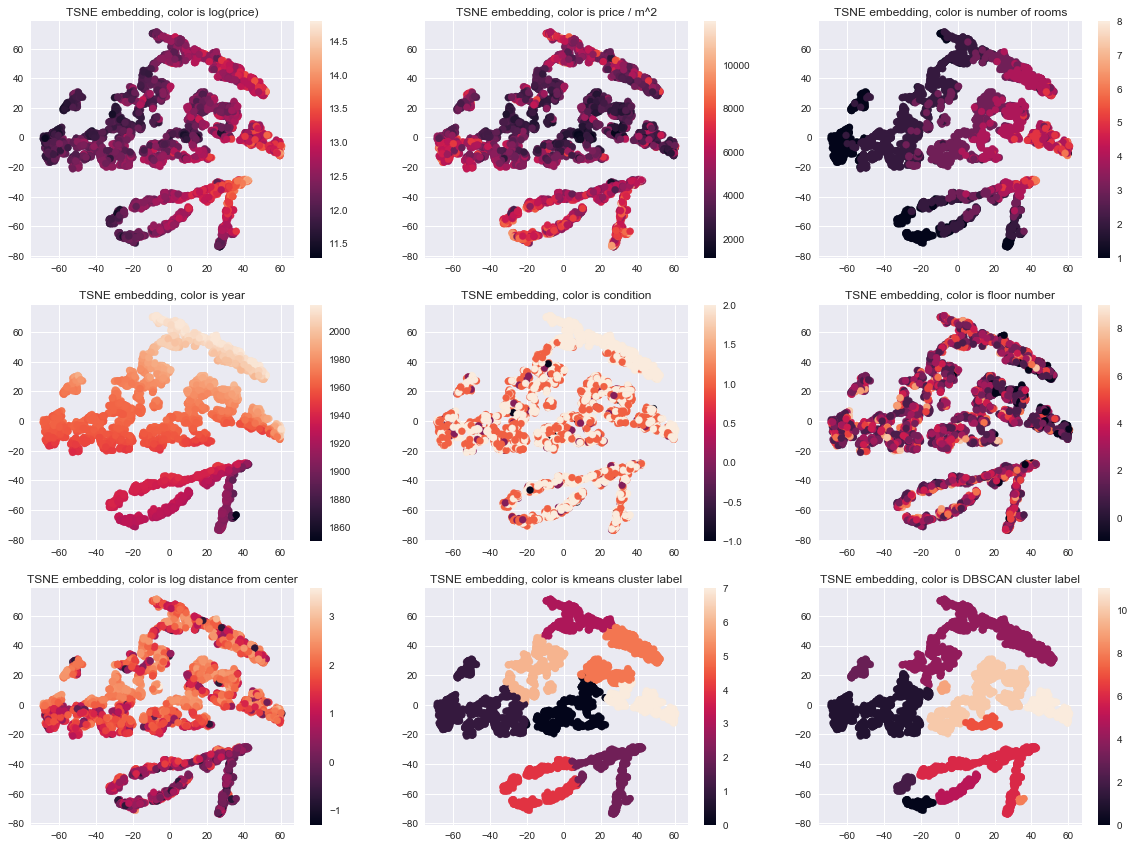

In [69]:
plt.figure(figsize=(20, 20))
plt.subplot(4,3,1)
plt.title('TSNE embedding, color is log(price)')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = np.log(data.price))
plt.colorbar()

plt.subplot(4,3,2)
plt.title('TSNE embedding, color is price / m^2')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.price_per_square_meter)
plt.colorbar()

plt.subplot(4,3,3)
plt.title('TSNE embedding, color is number of rooms')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.number_of_rooms)
plt.colorbar()

plt.subplot(4,3,4)
plt.title('TSNE embedding, color is year')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.year)
plt.colorbar()

plt.subplot(4,3,5)
plt.title('TSNE embedding, color is condition')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.condition)
plt.colorbar()

plt.subplot(4,3,6)
plt.title('TSNE embedding, color is floor number')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = data.floor_num)
plt.colorbar()

plt.subplot(4,3,7)
plt.title('TSNE embedding, color is log distance from center')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = np.log(data.dist_center))
plt.colorbar()


plt.subplot(4,3,8)
plt.title('TSNE embedding, color is kmeans cluster label')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = kmeans_labels)
plt.colorbar()

plt.subplot(4,3,9)
plt.title('TSNE embedding, color is DBSCAN cluster label')
plt.scatter(x = data_tsne_embedded[:,0], y = data_tsne_embedded[:,1], c = dbscan_labels)
plt.colorbar()

### PCA analysis
We next do PCA analysis for the data, similarly to the TSNE embedding. We see that the first two components explain 99.1% of the variance, so most likely it would be beneficial to use just these to fit the GP. 

0.9925895201960601


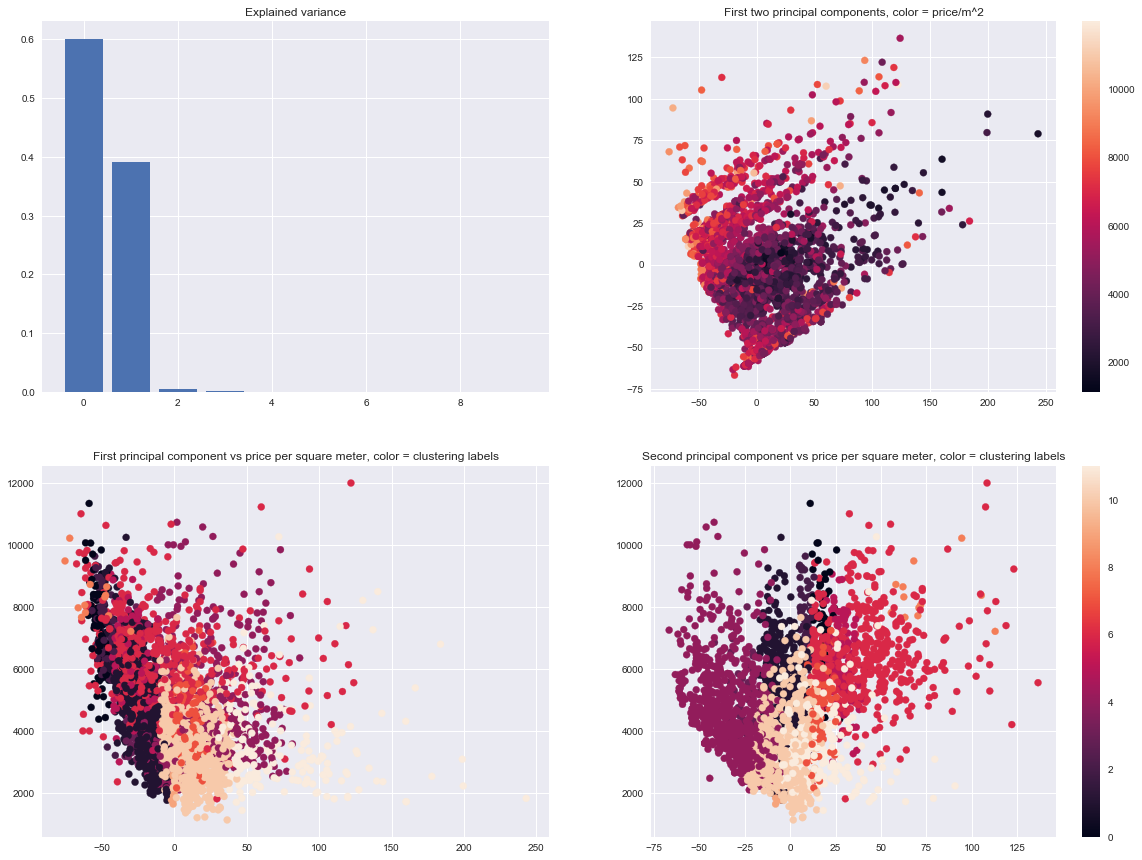

In [70]:
# TSNE, drop price and price per square meter as we want to predict those variables
pca_data = data.drop(columns=['price', 'price_per_square_meter'])

data_pca_model = PCA(n_components=10).fit(pca_data)
data_pca_embedded = PCA(n_components=10).fit_transform(pca_data)

components = data_pca_model.components_
ratios = data_pca_model.explained_variance_ratio_
print(ratios[0]+ ratios[1])

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.bar(np.arange(0,len(ratios)), ratios)
plt.title('Explained variance')

plt.subplot(2,2,2)
plt.title('First two principal components, color = price/m^2')
plt.scatter(x = data_pca_embedded[:,0], y = data_pca_embedded[:,1], c = data.price_per_square_meter)
plt.colorbar()

plt.subplot(2,2,3)
plt.title('First principal component vs price per square meter, color = clustering labels')
plt.scatter(x = data_pca_embedded[:,0], y = data.price_per_square_meter, c = dbscan_labels)

plt.subplot(2,2,4)
plt.title('Second principal component vs price per square meter, color = clustering labels')
plt.scatter(x = data_pca_embedded[:,1], y = data.price_per_square_meter, c = dbscan_labels)
plt.colorbar()

## GAUSSIAN PROCESS FIT

In [71]:
def model_information(model, x_test=None, y_test=None, plot_test_data = False):
    print(model)
 
    log_marginal_likelihood = model.log_likelihood()
    print('\nLog marginal likelihood:')
    print(log_marginal_likelihood)
     
    if x_test is not None and y_test is not None:
        predictions = model.predict(x_test)[0]
        mean_test_error = np.mean((predictions - y_test)**2)
        print('\nMean squared test error:')
        print(mean_test_error)

        mlppd = np.mean(model.log_predictive_density(x_test, y_test))
        print('\nMLPPD:')
        print(mlppd)
 
    fig = model.plot()
        
    if plot_test_data:
        fig_data = fig[0]['data']
        test_info = {'type': 'scatter', 
                     'x': np.squeeze(x_test,1), 
                     'y': np.squeeze(y_test,1), 
                     'mode': 'markers', 
                     'showlegend': True, 
                     'marker': {'color': 'red', 'colorscale': None}, 
                     'name': 'Test'}
        fig_data.append(test_info)
        fig[0]['data'] = fig_data
    
    
    GPy.plotting.show(fig)


### Train-test split
We split the complete data to train and test sets. The test set is data from year 2000 onwards.

In [72]:
# Split data to train and test sets
# Predict house prices after 2017
cutoff_year = 2000

train_data = data[data.year < cutoff_year]
test_data = data[data.year >= cutoff_year]

print('Train and test set sizes:')
print(len(train_data), len(test_data))

Train and test set sizes:
2803 524


### Baseline models

As a baseline to reach, we train kNN and Random Forest models. We try to surpass the performance of these models with the GPs.
They both have similar MSEs, about 300 000. We can also look at the random forest's feature importances to see which features influence the decisions the most.

Distance from city center is the most important feature by far. Square meters and year are the next most important features. Other features contribute little if at all.

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Mean squared test error:
3434638.565725191



KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

Mean squared test error:
2388541.042824427



RF feature importance


/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

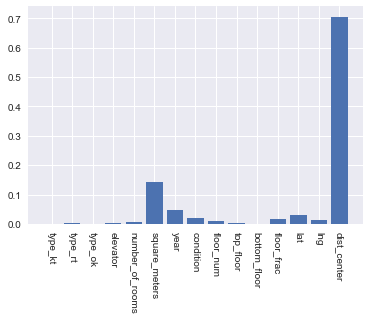

In [73]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

X_train_b = train_data.drop(columns=['price', 'price_per_square_meter'])
Y_train_b = np.array(train_data['price_per_square_meter'])[:, None]

X_test_b = test_data.drop(columns=['price', 'price_per_square_meter'])
Y_test_b = np.array(test_data['price_per_square_meter'])[:, None]

rf = RandomForestRegressor()
kn = KNeighborsRegressor()

rf.fit(X_train_b, Y_train_b)
kn.fit(X_train_b, Y_train_b)

for model in [rf, kn]:
    print(model)
    predictions = model.predict(X_test_b)[0]
    mean_test_error = np.mean((predictions - Y_test_b)**2)
    print('\nMean squared test error:')
    print(mean_test_error)
    print('\n\n')
    
print('RF feature importance')

plt.bar(range(0,15), rf.feature_importances_, tick_label = X_train_b.columns)
plt.xticks(rotation=-90)

### GP for price prediction per year
Let's do this boys: http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/sampling_hmc.ipynb
And some other stuff from here: http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/index.ipynb

In [74]:
X_train = np.array(train_data[['year']])
Y_train = np.array(train_data['price_per_square_meter'])[:, None]

X_test = np.array(test_data[['year']])
Y_test = np.array(test_data['price_per_square_meter'])[:, None]

kernel = GPy.kern.RBF(input_dim=X_train.shape[1], variance=10., lengthscale=1.) 

m = GPy.models.GPRegression(X_train, Y_train, kernel)
m.optimize(messages=True)

model_information(m, X_test, Y_test, plot_test_data = True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   2.125788e+09           nan 
    02s09  0002   1.260572e+09   3.133278e+17 
    08s06  0007   2.901310e+08   9.995693e+14 
    10s41  0009   1.640292e+08   1.048592e+14 
    15s16  0013   5.305113e+07   1.127940e+12 
    19s34  0017   1.717874e+07   1.398576e+10 
    23s24  0021   5.475499e+06   1.503774e+08 
    28s22  0026   1.330945e+06   1.777931e+06 
    35s05  0032   5.043179e+05   3.212887e+03 
    48s52  0046   2.943116e+04   3.623405e+01 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square




    50s55  0048   3.259247e+04           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:

invalid value encountered in multiply

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/optimization/verbose_optimization.py:160: RuntimeWarning:

invalid value encountered in less



    52s47  0050   2.780389e+04   2.892039e+01 
Runtime:     52s47
Optimization status: Converged


Name : GP regression
Objective : 27803.894840147368
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  161033.41776116047  |      +ve      |        
  rbf.lengthscale          |   79.40094141490552  |      +ve      |        
  Gaussian_noise.variance  |  355094.42170554696  |      +ve      |        

Log marginal likelihood:
-27803.894840147368

Mean squared test error:
7828532.784992042

MLPPD:
-18.211749588838828
This is the format of your plot grid:
[ (1,1) x1,y1 ]



### GP for PCA data
As the first two principal components account for 99% of the variance, we fit a GP to this transform. Now the GP is two dimensional, which makes constructing kernels more difficult.

In [75]:
data_pca_model = PCA(n_components=2).fit(pca_data)

# Construct pca train test sets
pca_train_X = data_pca_model.transform(train_data.drop(columns=['price', 'price_per_square_meter']))
pca_train_Y = np.array(train_data['price_per_square_meter'])[:, None]

pca_test_X = data_pca_model.transform(test_data.drop(columns=['price', 'price_per_square_meter']))
pca_test_Y = np.array(test_data['price_per_square_meter'])[:, None]

In [76]:
kernel = GPy.kern.RBF(input_dim=pca_train_X.shape[1], variance=1., lengthscale=1.) 
kernel += GPy.kern.RBF(input_dim=pca_train_X.shape[1], variance=10., lengthscale=1.) 
kernel += GPy.kern.Linear(input_dim=pca_train_X.shape[1])

m = GPy.models.GPRegression(pca_train_X, pca_train_Y, kernel)
m.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    04s91  0003   1.997489e+08   5.379218e+14 
    12s99  0008   5.143038e+07   3.512726e+12 
    18s20  0011   2.248256e+07   3.856142e+12 
    29s13  0018   3.324291e+06   5.642381e+08 
    41s97  0026   1.057020e+06   1.949891e+07 
    51s96  0032   1.962731e+05   7.819165e+04 
 01m01s88  0038   5.859099e+04   9.637139e+01 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square




 01m06s84  0041   3.508484e+04   1.829674e-02 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:

invalid value encountered in multiply



 01m15s73  0046   2.427598e+04           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/transformations.py:108: RuntimeWarning:

invalid value encountered in greater

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/optimization/verbose_optimization.py:160: RuntimeWarning:

invalid value encountered in less



 01m17s20  0047           nan           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/transformations.py:113: RuntimeWarning:

invalid value encountered in greater



 02m47s34  0108           nan           nan 
 03m15s39  0127           nan           nan 
Runtime:  03m15s39
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'



In [77]:
#Gpy.plotting.show(fig)
model_information(m, pca_test_X, pca_test_Y, plot_test_data = False)


Name : GP regression
Objective : 24275.981395602317
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  sum.rbf.variance         |       537172.3513707023  |      +ve      |        
  sum.rbf.lengthscale      |  5.562684646268137e-309  |      +ve      |        
  sum.rbf_1.variance       |       262861.4650250838  |      +ve      |        
  sum.rbf_1.lengthscale    |      18673.829524684137  |      +ve      |        
  sum.linear.variances     |      10723.841120239918  |      +ve      |        
  Gaussian_noise.variance  |       516565.8435036574  |      +ve      |        

Log marginal likelihood:
-24275.981395602317

Mean squared test error:
13148378.63257146


/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide




MLPPD:
-14.07540892898387
This is the format of your plot grid:
[ (1,1) x1,y1 ]



/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square



In [78]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square



In [79]:


slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing_vertical')



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square



In [80]:
m.optimize(messages=True)
#m.optimize_restarts(num_restarts = 10)

display(m)
fig = m.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   2.427598e+04           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:

overflow encountered in expm1

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:

invalid value encountered in multiply



    01s91  0001   2.427598e+04           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/transformations.py:108: RuntimeWarning:

invalid value encountered in greater




    03s83  0002           nan           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/transformations.py:113: RuntimeWarning:

invalid value encountered in greater

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/optimization/verbose_optimization.py:160: RuntimeWarning:

invalid value encountered in less



    08s44  0005           nan           nan 
    23s07  0015           nan           nan 
Runtime:     23s07
Optimization status: None

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 